In [180]:
import pickle
import numpy as np
import json
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import pandas as pd

In [78]:
# helper functions
def read_pickle(filepath):
    with open(filepath,"rb") as f:
        output = pickle.load(f)
    return output

def get_row_count(file_path):
    count = 0
    with open(file_path, 'r') as f:
        for line in f:
            count += 1
    return count

def list_to_dict(cur_list):
    cur_dict = dict()
    for i, label in enumerate(cur_list):
        cur_dict[label] = i
    return cur_dict

In [79]:
# given the path of the true labels and the label to id map
# return a numpy array of size (# of instance, # of labels)
# where each row is an n-hot vector indicating true label(s)
def get_truth_array(truth_path, label_to_id_map):
    
    truth_array = np.zeros((get_row_count(truth_path), len(label_to_id_map)), dtype = int)
    
    with open(truth_path, 'r') as truth_file:  
        for i, truth in enumerate(truth_file):
            true_labels = json.loads(truth)["doc_label"]
            for true_label in true_labels:
                true_id = label_to_id_map[true_label]
                truth_array[i][true_id] = 1
    return truth_array

In [80]:
# used for 3rd model (tencent)
def get_predicted_probs_from_json(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for prob in probs_file:
            probs.append(json.loads(prob))
    return np.array(probs)

In [115]:
# used for 2nd model (HFT-CNN)
def get_predicted_probs_from_json_with_header(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for i, prob in enumerate(probs_file):
            if i == 0:
                label_list = prob.rstrip().split(",")
            else:
                json_string = "[{}]".format(prob.rstrip())
                probs.append(json.loads(json_string))
    return list_to_dict(label_list), np.array(probs)

In [243]:
def prob_to_rank(probs):
    label_count = probs.shape[1]
    ranks = pd.DataFrame(probs).rank(axis=1, method='max')
    return np.array(ranks)

In [260]:
# generate pr curve
def get_pr_curve(truth_path, label_to_id_map, probs):
    truth_array = get_truth_array(truth_path, label_to_id_map)
    
    prob_precisions, prob_recalls, prob_thresholds = precision_recall_curve(truth_array.ravel(), probs.ravel())
    prob_average_precision = average_precision_score(truth_array, probs, average="micro")
    
    ranks = prob_to_rank(probs)
    rank_precisions, rank_recalls, rank_thresholds = precision_recall_curve(truth_array.ravel(), ranks.ravel())
    rank_average_precision = average_precision_score(truth_array, ranks, average="micro")
    
    plt.figure()
    plt.step(prob_recalls, prob_precisions, where='post', label='prob')
    plt.step(rank_recalls, rank_precisions, where='post', label='rank')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Average precision score: prob {0:0.2f} rank {1:0.2f}'
              .format(prob_average_precision, rank_average_precision))
    
    prob_result = prob_precisions, prob_recalls, prob_thresholds, prob_average_precision
    rank_result = rank_precisions, rank_recalls, rank_thresholds, rank_average_precision
    return prob_result, rank_result

In [261]:
def get_level_indices(subclass_label_to_id_map, level):
    indices = []
    new_map = dict()
    counter = 0
    for i, label in enumerate(subclass_label_to_id_map):
        if label.count("--") == level:
            indices.append(i)
            new_map[label] = counter
            counter += 1
    return np.array(indices), new_map

In [262]:
truth_path = "../../../../test.json"

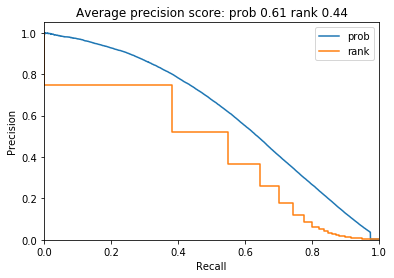

In [269]:
# 2nd model HFT-CNN (title abstract claim)
probs_path = "../../../../probability_3rd.txt"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curve(truth_path, subclass_label_to_id_map, probs)

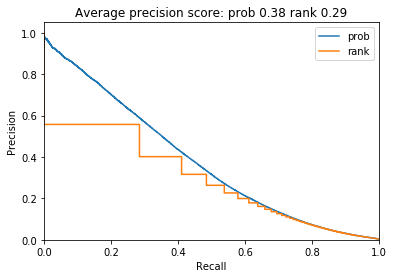

In [265]:
# 3rd model: tencent CNN (title abstract claim)

probs_path = "../../../../probs_claim.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_claim.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs(probs_path)

prob_result, rank_result = get_pr_curve(truth_path, subclass_label_to_id_map, probs)

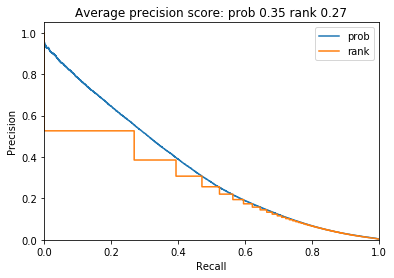

In [264]:
# 3rd model: tencent CNN (summary only)

probs_path = "../../../../probs_sum.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_sum.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs(probs_path)

prob_result, rank_result = get_pr_curve(truth_path, subclass_label_to_id_map, probs)

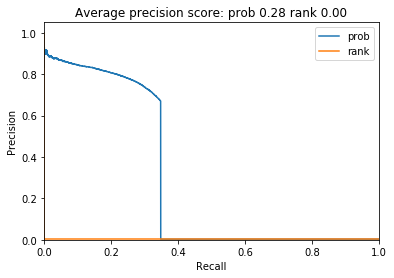

In [270]:
# 1st model: sklearn approach (title abstract claim)

probs_path = "../../../../test_dump_y_pred_parallel_RM"
label_to_id_maps_path = "../../../../mlb_classes"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_indices, subclass_label_to_id_map = get_level_indices(list_to_dict(label_to_id_list), 2)
    
probs = np.array(read_pickle(probs_path))[:, subclass_indices]
prob_result, rank_result = get_pr_curve(truth_path, subclass_label_to_id_map, probs)

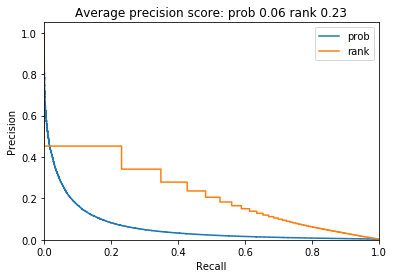

In [267]:
# 4th model: bottom-up approach (title abstract claim)

probs_path = "../../../../result_cos.save"
label_to_id_maps_path = "../../../../node_labels_cos.save"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = list_to_dict(label_to_id_list)
    
probs = np.array(read_pickle(probs_path))
prob_result, rank_result = get_pr_curve(truth_path, subclass_label_to_id_map, probs)

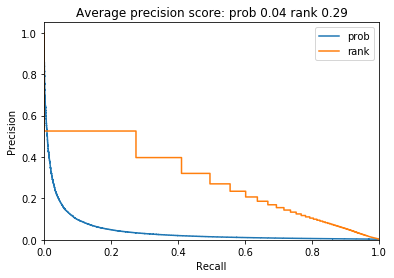

In [268]:
# 4th model: bottom-up approach (summary only)

probs_path = "../../../../result_cos_summary_only"
label_to_id_maps_path = "../../../../node_labels_cos_summary_only"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = dict()
for i, label in enumerate(label_to_id_list):
    subclass_label_to_id_map[label] = i
    
probs = np.array(read_pickle(probs_path))
prob_result, rank_result = get_pr_curve(truth_path, subclass_label_to_id_map, probs)